# Phase IV
In the last [notebook](https://github.com/Sylar257/Single-Shot-Detection-project/blob/master/Phase%20III--Gradual%20unfreezing%20and%20gradient%20clipping.ipynb), we built an SSD with batchnorm implemented for both base architecture and auxiliary layers that achieves pretty good resuilt(mAP = 0.791).<br>
In this notebook, we will implement some more modern technique and hopefully push the performance a little further.

## Learning optimal learning rate

SSD has two loss functions that we want to minimize: confidence loss & location loss (details included in later section).

As we are training the network jointly with the two loss, a natural question to ask is that what’s the optimal ratio of these two losses to back-propagate so that we have the best training efficiency. In the [original SSD paper](https://arxiv.org/pdf/1512.02325.pdf), this question is not answered by simply assigned `ratio = 1` to the two losses and it seemed to work just fine.

In the phase IV of this repo, we will be experimenting setting this ratio as two learnable parameters(one for each loss) following the guide in [this paper](https://zpascal.net/cvpr2017/Kendall_Geometric_Loss_Functions_CVPR_2017_paper.pdf).:
$$
L_\alpha(I) = L_c(I)\exp({-\hat{s_c}})+\hat{s_c}+L_l(I)\exp({-\hat{s_l}})+\hat{s_l}
$$

## Batchnorm implementation
  
  The original SSD architecture is Batchnorm-free. The inspiration is from this paper:[ScratchDet: Training Single-Shot Object Detectors from Scratch](https://arxiv.org/pdf/1810.08425.pdf). Objection detection’s current state-of-the-art detectors are generally fine-tuned from high accuracy classification networks. *e.g.*, VGGNet(which we will be using), ResNet and GoogLeNet **pre-trained** on ImageNet. There  both are advantages and disadvantages to use pre-trained base net. One of the primary reason not to train from scratch is that the optimization landscape is bumpy and not idea for training. Fortunately, now we have Batchnorm that could greatly mitigate this issue. This idea is introduced in [this paper](https://arxiv.org/pdf/1810.08425.pdf), and in this project’s Phase-III we shall utilize the idea of batchnorm to further improve our training result.
  
  Batch Normalization (BatchNorm) is a widely adopted technique that enables faster and more stable training of deep neural networks (DNNs). Despite its pervasiveness, the exact reasons for BatchNorm's effectiveness are still poorly understood. The popular belief is that this effectiveness stems from controlling the change of the layers' input distributions during training to reduce the so-called "internal covariate shift".(which was found out untrue in this paper: [How Does Batch Normalization Help Optimization?](https://arxiv.org/abs/1805.11604)) However, what it actually does, from a certain perspective, is to make the loss surface much more smoother so that our optimizer will have an easier time locating the global minimum.
  
![Loss_surfaces](images/Loss_surfaces.png)
  
   This paper has also shown that, “add batchnorm layers to every CNN layer” is more beneficial to if we train-from-scratch as compared to using a pre-trained model. The below table shows the performance of different result under various training conditions:
  
![pretraining_bn_backbong_head](images/pretraining_bn_backbong_head.png)

In [1]:
from torch import nn
from utils import *
import torch.nn.functional as F
from math import sqrt
from itertools import product as product
import numpy as np
import torchvision
import time
import torch.backends.cudnn as cudnn
import torch.utils.data
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from utils import transform
# specify GPU for cuda
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

In [2]:
class VGGBase_BN(nn.Module):
    """
    We implement VGG-16 here for low-level feature extraction
    """

    def __init__(self):
        super(VGGBase_BN, self).__init__()

        # Stabdard convolutional layers in VGG16
        # We have an input size of 300 by 300
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)   # stride = 1, output = (300+2-3)/1+1 = 300
        self.bn_1_1  = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # output = 300 as before
        self.bn_1_2  = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)          # output = (300-2)/2+1 = 150

        self.conv2_1 = nn.Conv2d(64,  128, kernel_size=3, padding=1)# output = (150+2-3)/1+1 = 150
        self.bn_2_1  = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)# output = (150+2-3)/1+1 = 150
        self.bn_2_2  = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)          # output = (150-2)/2 +1  = 75

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)# output = (75+2-3)/1+1 = 75
        self.bn_3_1  = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)# output = (75+2-3)/1+1 = 75
        self.bn_3_2  = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)# output = (75+2-3)/1+1 = 75
        self.bn_3_3  = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims
        # output = ceil((75-2)/2)-1 = 38   if floor we would be getting 37 here which is an odd number

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output = (38+2-3)/1+1 = 38
        self.bn_4_1  = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (38+2-3)/1+1 = 38
        self.bn_4_2  = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (38+2-3)/1+1 = 38
        self.bn_4_3  = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)           # output = (38-2)/2 +1  = 19

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (19+2-3)/1+1 = 19
        self.bn_5_1  = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (19+2-3)/1+1 = 19
        self.bn_5_2  = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (19+2-3)/1+1 = 19
        self.bn_5_3  = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # We retain the size at this step with padding and stride of 1
        # output = (19+2-3)/1+1 = 19

        # Here we replace the FC6 and FC7 with the technique introduce by sgrvinod(same with the original paper)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6) # output = (19+12-3-2*(6-1))/1+1 = 19

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)                       # output = (19-1)/1+1 = 19

        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward run with an image input of size 300 by 300
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.bn_1_1(self.conv1_1(image)))   # (N,64,300,300)
        out = F.relu(self.bn_1_2(self.conv1_2(out)))     # (N,64,300,300)
        out = self.pool1(out)               # (N,64,150,150)

        out = F.relu(self.bn_2_1(self.conv2_1(out)))  # (N,128,150,150)
        out = F.relu(self.bn_2_2(self.conv2_2(out)))  # (N,128,150,150)
        out = self.pool2(out)            # (N,128, 75, 75)

        out = F.relu(self.bn_3_1(self.conv3_1(out)))  # (N,256, 75, 75)
        out = F.relu(self.bn_3_2(self.conv3_2(out)))  # (N,256, 75, 75)
        out = F.relu(self.bn_3_3(self.conv3_3(out)))  # (N,256, 75, 75)
        out = self.pool3(out)            # (N,256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.bn_4_1(self.conv4_1(out)))  # (N, 512, 38, 38)
        out = F.relu(self.bn_4_2(self.conv4_2(out)))  # (N, 512, 38, 38)
        out = F.relu(self.bn_4_3(self.conv4_3(out)))  # (N, 512, 38, 38)
        # here we extract the feature from conv4_3
        conv4_3_feats = out              # (N, 512, 38, 38)
        out = self.pool4(out)            # (N, 512, 19, 19)

        out = F.relu(self.bn_5_1(self.conv5_1(out)))  # (N, 512, 19, 19)
        out = F.relu(self.bn_5_2(self.conv5_2(out)))  # (N, 512, 19, 19)
        out = F.relu(self.bn_5_3(self.conv5_3(out)))  # (N, 512, 19, 19)
        out = self.pool5(out)            # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))    # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        """
        Use pre-trained wieght from Torch Vsion. 
        Convert fc6 and fc7 weights into conv6 and conv7
        """
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16_bn(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.load_state_dict(state_dict)

        print("\nLoaded base model with pre-trained weights\n")

In [3]:
# Initializa AuxiliaryConvolutions with Kaiming_uniform_ and set non-linearity to 'relu'
# Implement Batchnorm in AuxiliaryConv layers

class AuxiliaryConvolutions_BN(nn.Module):
    """
    These layers are put on top of base model to produce more feature maps for object detections.(smaller maps)
    """

    def __init__(self):
        super(AuxiliaryConvolutions_BN, self).__init__()

        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)         # output=(19-1)/1+1 = 19
        self.bn_8_1  = nn.BatchNorm2d(256)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)# output=(19+2-3)/2+1 = 10
        self.bn_8_2  = nn.BatchNorm2d(512)

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)          # output=(10-1)/1+1 = 10
        self.bn_9_1  = nn.BatchNorm2d(128)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)# output=(10+2-3)/2+1 = 5 because by defaul we use "floor"
        self.bn_9_2  = nn.BatchNorm2d(256)
        
        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)         # output=(5-1)/1+1 = 5
        self.bn_10_1  = nn.BatchNorm2d(128)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)         # output=(5-3)/1+1 = 3
        self.bn_10_2  = nn.BatchNorm2d(256)
        
        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)         # output=(3-1)/1+1 = 3
        self.bn_11_1  = nn.BatchNorm2d(128)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)         # output=(3-3)/1+1 = 1
        self.bn_11_2  = nn.BatchNorm2d(256)
        
        self.init_conv2d()
        print('Using Batchnorm version')
        
    def init_conv2d(self):
        """
        Initialize convolution parameters
        """
        for i, c in enumerate(self.children()):
            if isinstance(c, nn.Conv2d):
                nn.init.kaiming_uniform_(c.weight, nonlinearity='relu')
                nn.init.constant_(c.bias, 0.)
            elif isinstance(c, nn.BatchNorm2d):
                c.reset_parameters()
                print(f'layer {i} is initialized as BatchNorm2d')
                
    def forward(self, conv7_feats):
        """
        conv7_feats: (N, 1024, 19, 19)
        return: higher-level feature maps conv8_2, conv9_2, conv10_2, and conv11_2
        """
        out = F.relu(self.bn_8_1(self.conv8_1(conv7_feats)))  # (N, 256, 19, 19)
        out = F.relu(self.bn_8_2(self.conv8_2(out)))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = F.relu(self.bn_9_1(self.conv9_1(out)))  # (N, 128, 10, 10)
        out = F.relu(self.bn_9_2(self.conv9_2(out)))  # (N, 256, 5, 5)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = F.relu(self.bn_10_1(self.conv10_1(out)))  # (N, 128, 5, 5)
        out = F.relu(self.bn_10_2(self.conv10_2(out)))  # (N, 256, 3, 3)
        conv10_2_feats = out  # (N, 256, 3, 3)

        out = F.relu(self.bn_11_1(self.conv11_1(out)))  # (N, 128, 3, 3)
        conv11_2_feats = F.relu(self.bn_11_2(self.conv11_2(out)))  # (N, 256, 1, 1)

        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats
    

In [4]:
# Same as above, we replace xavier_uniform with kaiming_uniform_

class PredictionConvolutions(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher level feature maps

    The bounding boxes (offsets (g_{c_x}, g_{c_y}, g_w, g_h) of the 8732 default priors)
    See 'cxcy_to_gcxgcy' in utils.py for encoding definition

    The class scores represent the scores of each object class in each of the 8732 hounding boxes
    A high score for 'background' = no object
    """

    def __init__(self, n_classes):
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Number of proior_boxes we are considering per position in each feature map
        n_boxes = {'conv4_3': 4,
                    'conv7': 6,
                    'conv8_2': 6,
                    'conv9_2': 6,
                    'conv10_2': 4,
                    'conv11_2': 4}
        # 4 prior-boxes prediction convoluitions (predict offsets w.r.t prior-boxes)

        # This is the part to compute LOCALIZATION prediction
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3']*4, kernel_size=3, padding=1) # output = (38-3+2)/1+1 = 38, same padding
        self.loc_conv7   = nn.Conv2d(1024, n_boxes['conv7']*4, kernel_size=3, padding=1)  # output = (19-3+2)/1+1 = 19
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2']*4, kernel_size=3, padding=1) # output = (10-3+2)/1+1 = 10
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2']*4, kernel_size=3, padding=1) # output = (5-3+2)/1 +1 = 5
        self.loc_conv10_2= nn.Conv2d(256, n_boxes['conv10_2']*4,kernel_size=3, padding=1) # output = (3-3+2)/1 +1 = 3
        self.loc_conv11_2= nn.Conv2d(256, n_boxes['conv11_2']*4,kernel_size=3, padding=1) # output = (1-3+2)/1 +1 = 1

        # This is the part to comput CLASS prediction
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7   = nn.Conv2d(1024,n_boxes['conv7']   * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256,n_boxes['conv10_2'] * n_classes,kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256,n_boxes['conv11_2'] * n_classes,kernel_size=3, padding=1)

        self.init_conv2d()
    def init_conv2d(self):
        # Use Kaiming_uniform_ here instead of xavier_uniform_
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.kaiming_uniform_(c.weight, nonlinearity='relu')
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        """
        Forward propagation.
        :param conv4_3_feats: conv4_3 feature map, a tensor of dimensions (N, 512, 38, 38)
        :param conv7_feats: conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :param conv8_2_feats: conv8_2 feature map, a tensor of dimensions (N, 512, 10, 10)
        :param conv9_2_feats: conv9_2 feature map, a tensor of dimensions (N, 256, 5, 5)
        :param conv10_2_feats: conv10_2 feature map, a tensor of dimensions (N, 256, 3, 3)
        :param conv11_2_feats: conv11_2 feature map, a tensor of dimensions (N, 256, 1, 1)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        batch_size = conv4_3_feats.size(0)

        # Predict localization boxes' bounds w.r.t prior boxes
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)            # (N, 16, 38, 38)  16 is from 4 priors 4*4=16
        l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous() # (N, 38, 38, 16)  to match prior-box order (after .view())
        # .contiguous() ensures it is stores in a contiguous chunk of memory, needed for .view() below

        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)          # This give us (N, 5776, 4) the (g_{c_x}, g_{c_y}, g_w, g_h) for all 5776 priors

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(batch_size, -1, 4)  # (N, 2166, 4), there are a total 2116 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 16)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  # (N, 4, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 4 * n_classes), to match prior-box order (after .view())
        c_conv4_3 = c_conv4_3.view(batch_size, -1,
                                    self.n_classes)  # (N, 5776, n_classes), there are a total 5776 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1,
                                self.n_classes)  # (N, 2166, n_classes), there are a total 2116 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 4 * n_classes)
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  # (N, 4, n_classes)

        # A total of 8732 boxes
        # Concatenate in this specific order    
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1)  # (N, 8732, n_classes)

        return locs, classes_scores

In [5]:
class SSD300(nn.Module):
    def __init__(self, n_classes):

        """
        This class works as a wrapper that encapsulates the base VGG network, auxiliary, and prediciton convolutions.
        """
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = VGGBase_BN()
        self.aux_convs = AuxiliaryConvolutions_BN()
        self.pred_convs = PredictionConvolutions(n_classes)

        # Since lower level features (conv4_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factor = nn.Parameter(torch.FloatTensor(1, 512, 1, 1)) # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factor, 20)

        # The above two lines demonstrate a simple example of how do add a leanable-parameter into our computation

        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()  # with shape of (8732, 4)

    def create_prior_boxes(self):
        """
        Create the 8732 prior (default) boxes for the SSD300, as defined in the paper.
        :return: prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes
    
    def forward(self, image):
        """
        Forward propagation

        image: (N, 3, 300, 300)
        return:  8732 locations and class scores (i.e.  w.r.t each prior box) for the given image(s)
        """

        # Run VGG base network convolutions (lower level feature map generators, up to conv7)
        conv4_3_feats, conv7_feats = self.base(image)   # (N, 512, 38, 38),  (N, 1024, 19, 19)

        # Rescale conv4_3 after L2 norm using our learnable parameter
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm                         # (N, 512, 38, 38) this step was done by broadcasting
        conv4_3_feats = conv4_3_feats*self.rescale_factor            # (N, 512, 38, 38)

        # Run auxiliaury convolution (higher level feature map extraction)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = self.aux_convs(conv7_feats) 
        # (N, 512, 10, 10), (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

        # Run prediction convolutions (predict offset w.r.t. priors and classes in each resulting location)
        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats)
        # (N, 8732, 4), (N, 8732, n_classes)

        return locs, classes_scores
    
    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of our forward pass) to detect objects.

        For each class. perform Non-Maximum Suppression (NMS) on boxes that are above a minimum score

        predicted_locs: predicted locations w.r.t the 8732 prior boxes, a tensor of (N, 8732, 4)
        predicted_scores: predicted class score for each of prediced locations, a tensor of (N, 8732, n_classes)
        min_score: the minimun score for a box to be consifered a match for a CERTAIN CLASS
        max_overlap: the maximum overlap that we allow. For any pair of boxes with higher overlap, the lower class score one will be suppressed
        top_k: if there are a lot of resulting detection across all classes, keep only the top_k 
        
        return: detections (boxes, labels, and scores), lists of length batch_size N
        """
        batch_size = predicted_locs.size(0) # N
        n_priors = self.priors_cxcy.size(0) # 8732
        predicted_scores = F.softmax(predicted_scores, dim=2) # (N, 8732, n_classes)

        # list to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_scores = list()
        all_images_labels = list()

        assert n_priors == predicted_scores.size(1) == predicted_locs.size(1)

        for i in range(batch_size):
            # Convert diviation from prior boxes to (c_x, c_y, w, h)
            # Convert bounding boxes from center-size coordinates (c_x, c_y, w, h) to boundary coordinates (x_min, y_min, x_max, y_max)
            
            decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_scores = list()
            image_labels = list()

            max_score,  best_label = predicted_scores[i].max(dim=1) # (8732), (8732)

            # operations for each class. Class 0 is not included here because it denotes background(negative)
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above minimum_score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score # torch.uint8 (byte) tensor, for infexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                # here, we will retain the score & locs of the boxes with score higher than the threshold
                class_scores = class_scores[score_above_min_score] # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score] # (n_qualfied, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs) # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)
                
                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

In [6]:
class MultiBoxLoss(nn.Module):
    """
    This is the version with learnable alpha implemented
    The Multibox loss function for SSD300 architecture, which is a combination of:

    1) a localization loss for the predicted locations of the boxes, and
    2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha_C=0., alpha_L=1.5):
        """
        priors_cxcy: priors' (c_x, c_y, w, h)
        threshold: overlapping less than 'threshold' with priors are set to class-background
        neg_pos_ratio: a parameter used when calculating hard negative mining. Detail in forward() section
        alpha: the ratio between localization loss and confidence loss
        """
        
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha_C = nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        nn.init.constant_(self.alpha_C, alpha_C)
        self.alpha_L = nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        nn.init.constant_(self.alpha_L, alpha_L)
        
        # the two loss functions for localization and classification
        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)
        
    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.

        predicted_locs:   predicted locations/box w.r.t 8732 priors, (N, 8732, 4)
        predicted_scores: preidted class scores for each of the encoded locations, (N, 8732, n_classes)
        boxes:            ground truth boxes,  a list of N tensors
        label:            ground truth labels, a list of N tensors
        """

        batch_size = predicted_locs.size(0)
        n_priors   = self.priors_cxcy.size(0)
        n_classes  = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)   # (N, 8732)

        # for each image in the minibatch
        for i in range(batch_size):
            n_objects = boxes[i].size(0) # the number of objects exist in the given image

            overlap = find_jaccard_overlap(boxes[i], self.priors_xy)  # (n_objects, 8732)

            # for each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0) # (8732),  (8732)

            # we dont want a situation where an object is not represented in our positive (non-background) priors for reasons like:
            # 1. An objext might not be the best object for all priors, and is theresore not in the object_for_each_prior
            # 2. All priors with the object may be assigned as background based on the threshold (0.5 by defaul)

            # to remedy this
            # first, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)   # (n_object)

            # Then, assign each object to the corresponding maximum-overlap-prior. (this fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS
        total_loss = loc_loss*torch.exp(self.alpha_L)-self.alpha_L+conf_loss*torch.exp(self.alpha_C)-self.alpha_C

        return total_loss

In [7]:
class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used as DataLoader later
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        data_folder: folder where data files are stored
        split: this must be either 'TRAIN' or 'TEST'
        keep_difficult: keep or discard objects that are considered as difficult(a property come with the dataset)
        """
        self.split = split.upper()

        assert self.split in {'TRAIN','TEST'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        with open(os.path.join(data_folder,self.split+'_images.json'),   'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split+'_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)
    
    def __getitem__(self, i):
        # Read Image
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')

        # Read objects in this image (bounding boxes, labels, difficulties)
        objects = self.objects[i]
        boxes  = torch.FloatTensor(objects['boxes']) # (n_objects, 4)
        labels = torch.LongTensor(objects['labels']) # (n_objects)
        difficulties = torch.ByteTensor(objects['difficulties'])  # (n_objects)

        # Discard difficult objects, if specified
        if not self.keep_difficult:
            boxes = boxes[1-difficulties]
            labels = labels[1-difficulties]
            difficulties = difficulties[1-difficulties]

        # Apply transformations
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, self.split)

        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader)

        This describes how to combine these tensors of different sizes. We use lists.

        @Params
        batch: an iterable of N sets from __getitem__()
        return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes  = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each

### Learning rate annealing
In the first phase, we used a constant learning rate in our training loop. 
Decay the learning rate by a ratio of 0.9, when our model cease to make an improvemnet. 
This was recommentded in the [original paper](https://arxiv.org/abs/1512.02325). <br>
What we are going to do differently this time is to implement a learning rate scheduler that anneal our learning rate in a way that it has a period of "warming up & catch up speed", followed by a period of "high learning rate" then gradually slow down to find good convergence.

In [8]:
import torch
import math
import matplotlib.pyplot as plt
from functools import partial
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos): return start
@annealer
def sched_exp(start, end, pos): return start*(end/start)**pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

### Here we will build different annealing options
Cosine scheduling will be implemented later same as it's done in FastAI library

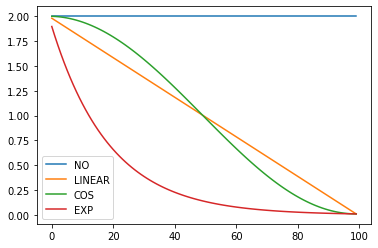

In [9]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [10]:
from torch import tensor
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + list(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

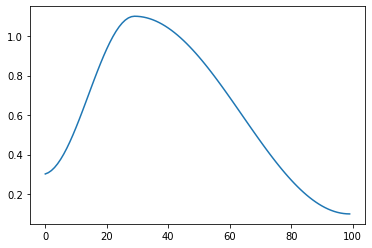

In [11]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 1.1), sched_cos(1.1, 0.1)])
plt.plot(a, [sched(o) for o in p])

In [12]:
import functools, traceback
import sys, fastai
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

In [13]:
# the learning rate scheduler used in training loop
sched = combine_scheds([0.3, 0.7], [sched_cos(1e-5, 4e-3), sched_cos(4e-3, 1e-6)])

@gpu_mem_restore
def train(train_loader, model, criterion, optimizer, epoch, total_iters):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    :param total_iters: total_number of iterations
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar
        
        # learning rate annealing
        current_iter = epoch*n_batches+i
        
        # learning rate anealing and visualization for later
    
        optimizer.param_groups[0]['lr'] = sched(current_iter/total_iters)*2    # this is the bias group

        optimizer.param_groups[1]['lr'] = sched(current_iter/total_iters)      # this is the non-bias group

        learning_rates.append(optimizer.param_groups[1]['lr'])

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))            
            print(f'alpha_loc: {criterion.alpha_L}, alpha_conf: {criterion.alpha_C}')
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored


def validate(val_loader, model, criterion):
    """
    One epoch's validation.
    :param val_loader: DataLoader for validation data
    :param model: model
    :param criterion: MultiBox loss
    :return: average validation loss
    """
    model.eval()  # eval mode disables dropout

    batch_time = AverageMeter()
    losses = AverageMeter()

    start = time.time()

    # Prohibit gradient computation explicity because I had some problems with memory
    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(val_loader):

            # Move to default device
            images = images.to(device)  # (N, 3, 300, 300)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]

            # Forward prop.
            predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

            # Loss
            loss = criterion(predicted_locs, predicted_scores, boxes, labels)

            losses.update(loss.item(), images.size(0))
            batch_time.update(time.time() - start)

            start = time.time()

            # Print status
            if i % print_freq == 0:
                print('[{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(i, len(val_loader),
                                                                      batch_time=batch_time,
                                                                      loss=losses))

    print('\n * LOSS - {loss.avg:.3f}\n'.format(loss=losses))

    return losses.avg

In [ ]:
# Training SSD300 with Kaiming_uniform_ and learning rate annealing
global epochs_since_improvement, start_epoch, label_map, best_loss, epoch, checkpoint

data_folder = './'
keep_difficult = True
n_classes = len(label_map)

# Training parameters
checkpoint = None  # path to model checkpoint if consider resume training from there
batch_size = 16
start_epoch = 0    # start at this epoch
epochs = 300       # total training epochs to run without early-stopping
epochs_since_improvement = 0 # record the no. of epochs since last improvement
best_loss = 100.   # assume a hight loss at first
workers = 4        # number of workers for loading data in the DataLoader
print_freq = 200   # print training or validation status every __ batches
lr = 1e-3/2          # learning rate
momentum = 0.9     
weight_decay = 5e-4
grad_clip = 5.   # consider clipping the gradient when using high learning_rate

# torch.cuda.empty_cache()
cudnn.benchmark = True


# initialize model or load checkpoint
if checkpoint is None:
    model = SSD300(n_classes)
    # Initialize the optimizer, with twice the default learning rate for biases
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device) # Loss function to GPU
    
    biases = list()
    not_biases = list()
    for param_name, param in model.named_parameters():
        if param.requires_grad:
            if param_name.endswith('.bias'):
                biases.append(param)
            else:
                not_biases.append(param)
    for param_name, param in criterion.named_parameters():
        not_biases.append(param)
        
    optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)
else:
    checkpoint = torch.load(checkpoint)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device) # Loss function to GPU
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_loss = checkpoint['best_loss']
    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
    
# move to  default device
torch.cuda.empty_cache()
model = model.to(device)      # model to GPU


# Custom dataloaders
train_dataset = PascalVOCDataset(data_folder,'train',keep_difficult)
val_dataset   = PascalVOCDataset(data_folder,'test' ,keep_difficult)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                            collate_fn=train_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True) # pass in our collate function here
val_loader    = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                                             collate_fn=val_dataset.collate_fn, num_workers=workers,
                                             pin_memory=True)
# used to schedule learning rate later
n_batches = len(train_loader)

learning_rates = list()
total_iters = epochs*n_batches

# Epochs
for epoch in range(start_epoch, epochs):
            
    train(train_loader=train_loader,
          model=model,
          criterion=criterion,
          optimizer=optimizer,
          epoch=epoch,
          total_iters=total_iters
          )

    # One epoch's validation
    val_loss = validate(val_loader=val_loader,
                        model=model,
                        criterion=criterion)

    # Did validation loss improve?
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)

    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

    else:
        epochs_since_improvement = 0

    # Save checkpoint
    save_checkpoint(epoch, epochs_since_improvement, model, optimizer, val_loss, best_loss, is_best)


Loaded base model with pre-trained weights

layer 1 is initialized as BatchNorm2d
layer 3 is initialized as BatchNorm2d
layer 5 is initialized as BatchNorm2d
layer 7 is initialized as BatchNorm2d
layer 9 is initialized as BatchNorm2d
layer 11 is initialized as BatchNorm2d
layer 13 is initialized as BatchNorm2d
layer 15 is initialized as BatchNorm2d
Using Batchnorm version


/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [0][0/1035]	Batch Time 6.398 (6.398)	Data Time 0.913 (0.913)	Loss 28.2573 (28.2573)	
alpha_loc: Parameter containing:
tensor([1.5000], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-5.0000e-05], device='cuda:0', requires_grad=True)
Epoch: [0][200/1035]	Batch Time 0.405 (0.406)	Data Time 0.000 (0.007)	Loss 17.9178 (21.1958)	
alpha_loc: Parameter containing:
tensor([1.4176], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.0962], device='cuda:0', requires_grad=True)
Epoch: [0][400/1035]	Batch Time 0.402 (0.392)	Data Time 0.001 (0.005)	Loss 15.1401 (18.5630)	
alpha_loc: Parameter containing:
tensor([1.3402], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.1972], device='cuda:0', requires_grad=True)
Epoch: [0][600/1035]	Batch Time 0.400 (0.388)	Data Time 0.001 (0.005)	Loss 12.8696 (17.0123)	
alpha_loc: Parameter containing:
tensor([1.2694], device='cuda:0', requires_grad=True), alp

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SSD300. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type VGGBase_BN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AuxiliaryConvolutions_BN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PredictionConvol

Epoch: [1][0/1035]	Batch Time 1.206 (1.206)	Data Time 0.772 (0.772)	Loss 10.6154 (10.6154)	
alpha_loc: Parameter containing:
tensor([1.1316], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.5345], device='cuda:0', requires_grad=True)
Epoch: [1][200/1035]	Batch Time 0.367 (0.385)	Data Time 0.000 (0.005)	Loss 9.0845 (9.9006)	
alpha_loc: Parameter containing:
tensor([1.0731], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.6491], device='cuda:0', requires_grad=True)
Epoch: [1][400/1035]	Batch Time 0.366 (0.382)	Data Time 0.001 (0.003)	Loss 8.4166 (9.4486)	
alpha_loc: Parameter containing:
tensor([1.0166], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7670], device='cuda:0', requires_grad=True)
Epoch: [1][600/1035]	Batch Time 0.404 (0.382)	Data Time 0.000 (0.003)	Loss 8.1158 (9.0412)	
alpha_loc: Parameter containing:
tensor([0.9624], device='cuda:0', requires_grad=True), alpha_conf: P

Epoch: [5][1000/1035]	Batch Time 0.357 (0.379)	Data Time 0.000 (0.003)	Loss 4.1703 (4.3227)	
alpha_loc: Parameter containing:
tensor([0.0927], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-2.0309], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.497 (0.497)	Loss 4.2500 (4.2500)	
[200/310]	Batch Time 0.145 (0.165)	Loss 4.2719 (4.2089)	

 * LOSS - 4.209

Epoch: [6][0/1035]	Batch Time 1.374 (1.374)	Data Time 0.945 (0.945)	Loss 4.2480 (4.2480)	
alpha_loc: Parameter containing:
tensor([0.0891], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-2.0331], device='cuda:0', requires_grad=True)
Epoch: [6][200/1035]	Batch Time 0.424 (0.386)	Data Time 0.000 (0.006)	Loss 4.2244 (4.2206)	
alpha_loc: Parameter containing:
tensor([0.0709], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-2.0438], device='cuda:0', requires_grad=True)
Epoch: [6][400/1035]	Batch Time 0.368 (0.382)	Data Time 0.003 (0

Epoch: [10][600/1035]	Batch Time 0.384 (0.379)	Data Time 0.009 (0.003)	Loss 3.6803 (3.7235)	
alpha_loc: Parameter containing:
tensor([0.0092], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.7800], device='cuda:0', requires_grad=True)
Epoch: [10][800/1035]	Batch Time 0.380 (0.379)	Data Time 0.000 (0.002)	Loss 3.5978 (3.7148)	
alpha_loc: Parameter containing:
tensor([0.0156], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.7644], device='cuda:0', requires_grad=True)
Epoch: [10][1000/1035]	Batch Time 0.419 (0.379)	Data Time 0.001 (0.002)	Loss 3.6920 (3.7096)	
alpha_loc: Parameter containing:
tensor([0.0198], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.7522], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.636 (0.636)	Loss 3.5999 (3.5999)	
[200/310]	Batch Time 0.176 (0.165)	Loss 3.6764 (3.6546)	

 * LOSS - 3.655

Epoch: [11][0/1035]	Batch Time 1.433 (1.433)	Data Time 1.01

Epoch: [15][200/1035]	Batch Time 0.365 (0.386)	Data Time 0.000 (0.007)	Loss 3.4626 (3.4116)	
alpha_loc: Parameter containing:
tensor([0.1444], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.5737], device='cuda:0', requires_grad=True)
Epoch: [15][400/1035]	Batch Time 0.363 (0.382)	Data Time 0.001 (0.004)	Loss 3.2900 (3.4063)	
alpha_loc: Parameter containing:
tensor([0.1535], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.5698], device='cuda:0', requires_grad=True)
Epoch: [15][600/1035]	Batch Time 0.390 (0.381)	Data Time 0.000 (0.003)	Loss 3.3370 (3.4107)	
alpha_loc: Parameter containing:
tensor([0.1524], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.5692], device='cuda:0', requires_grad=True)
Epoch: [15][800/1035]	Batch Time 0.364 (0.381)	Data Time 0.001 (0.003)	Loss 3.4535 (3.4105)	
alpha_loc: Parameter containing:
tensor([0.1522], device='cuda:0', requires_grad=True), alpha_con

[0/310]	Batch Time 0.671 (0.671)	Loss 3.0045 (3.0045)	
[200/310]	Batch Time 0.157 (0.165)	Loss 3.3447 (3.1831)	

 * LOSS - 3.179

Epoch: [20][0/1035]	Batch Time 1.386 (1.386)	Data Time 0.963 (0.963)	Loss 3.1360 (3.1360)	
alpha_loc: Parameter containing:
tensor([0.2664], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.4540], device='cuda:0', requires_grad=True)
Epoch: [20][200/1035]	Batch Time 0.406 (0.381)	Data Time 0.001 (0.006)	Loss 2.9445 (3.1763)	
alpha_loc: Parameter containing:
tensor([0.2704], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.4521], device='cuda:0', requires_grad=True)
Epoch: [20][400/1035]	Batch Time 0.366 (0.381)	Data Time 0.000 (0.004)	Loss 3.3308 (3.1734)	
alpha_loc: Parameter containing:
tensor([0.2748], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.4474], device='cuda:0', requires_grad=True)
Epoch: [20][600/1035]	Batch Time 0.372 (0.380)	Data Time 0.001

Epoch: [24][800/1035]	Batch Time 0.418 (0.380)	Data Time 0.024 (0.003)	Loss 3.1288 (3.0004)	
alpha_loc: Parameter containing:
tensor([0.3472], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.3403], device='cuda:0', requires_grad=True)
Epoch: [24][1000/1035]	Batch Time 0.365 (0.381)	Data Time 0.000 (0.002)	Loss 3.0153 (2.9965)	
alpha_loc: Parameter containing:
tensor([0.3487], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.3343], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.460 (0.460)	Loss 3.0921 (3.0921)	
[200/310]	Batch Time 0.154 (0.167)	Loss 2.9872 (2.9760)	

 * LOSS - 2.972

Epoch: [25][0/1035]	Batch Time 1.467 (1.467)	Data Time 1.004 (1.004)	Loss 2.8804 (2.8804)	
alpha_loc: Parameter containing:
tensor([0.3463], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.3347], device='cuda:0', requires_grad=True)
Epoch: [25][200/1035]	Batch Time 0.416 (0.385)	Data Time 0.00

Epoch: [29][400/1035]	Batch Time 0.379 (0.381)	Data Time 0.000 (0.004)	Loss 2.8000 (2.8168)	
alpha_loc: Parameter containing:
tensor([0.4233], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.2302], device='cuda:0', requires_grad=True)
Epoch: [29][600/1035]	Batch Time 0.367 (0.381)	Data Time 0.001 (0.004)	Loss 2.8834 (2.8202)	
alpha_loc: Parameter containing:
tensor([0.4006], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.2254], device='cuda:0', requires_grad=True)
Epoch: [29][800/1035]	Batch Time 0.362 (0.382)	Data Time 0.000 (0.003)	Loss 2.7546 (2.8174)	
alpha_loc: Parameter containing:
tensor([0.4106], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.2228], device='cuda:0', requires_grad=True)
Epoch: [29][1000/1035]	Batch Time 0.380 (0.382)	Data Time 0.000 (0.003)	Loss 2.6613 (2.8154)	
alpha_loc: Parameter containing:
tensor([0.4094], device='cuda:0', requires_grad=True), alpha_co

Epoch: [34][0/1035]	Batch Time 1.110 (1.110)	Data Time 0.694 (0.694)	Loss 2.6334 (2.6334)	
alpha_loc: Parameter containing:
tensor([0.4606], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.1409], device='cuda:0', requires_grad=True)
Epoch: [34][200/1035]	Batch Time 0.426 (0.385)	Data Time 0.001 (0.005)	Loss 2.7325 (2.6600)	
alpha_loc: Parameter containing:
tensor([0.4696], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.1379], device='cuda:0', requires_grad=True)
Epoch: [34][400/1035]	Batch Time 0.413 (0.384)	Data Time 0.000 (0.003)	Loss 2.8801 (2.6763)	
alpha_loc: Parameter containing:
tensor([0.4559], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.1353], device='cuda:0', requires_grad=True)
Epoch: [34][600/1035]	Batch Time 0.406 (0.382)	Data Time 0.000 (0.003)	Loss 2.5414 (2.6737)	
alpha_loc: Parameter containing:
tensor([0.4662], device='cuda:0', requires_grad=True), alpha_conf:

Epoch: [38][1000/1035]	Batch Time 0.361 (0.380)	Data Time 0.000 (0.003)	Loss 2.5086 (2.5715)	
alpha_loc: Parameter containing:
tensor([0.5018], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.0581], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.568 (0.568)	Loss 2.5622 (2.5622)	
[200/310]	Batch Time 0.157 (0.166)	Loss 2.4750 (2.5647)	

 * LOSS - 2.569

Epoch: [39][0/1035]	Batch Time 1.584 (1.584)	Data Time 1.171 (1.171)	Loss 2.4833 (2.4833)	
alpha_loc: Parameter containing:
tensor([0.5004], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.0631], device='cuda:0', requires_grad=True)
Epoch: [39][200/1035]	Batch Time 0.408 (0.390)	Data Time 0.000 (0.008)	Loss 2.3363 (2.5660)	
alpha_loc: Parameter containing:
tensor([0.4876], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.0667], device='cuda:0', requires_grad=True)
Epoch: [39][400/1035]	Batch Time 0.365 (0.385)	Data Time 0.00

Epoch: [43][600/1035]	Batch Time 0.368 (0.381)	Data Time 0.000 (0.003)	Loss 2.4428 (2.4773)	
alpha_loc: Parameter containing:
tensor([0.5383], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.0105], device='cuda:0', requires_grad=True)
Epoch: [43][800/1035]	Batch Time 0.378 (0.380)	Data Time 0.000 (0.003)	Loss 2.2226 (2.4783)	
alpha_loc: Parameter containing:
tensor([0.5356], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-1.0060], device='cuda:0', requires_grad=True)
Epoch: [43][1000/1035]	Batch Time 0.408 (0.380)	Data Time 0.001 (0.002)	Loss 2.1902 (2.4762)	
alpha_loc: Parameter containing:
tensor([0.5425], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.9942], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.617 (0.617)	Loss 2.3942 (2.3942)	
[200/310]	Batch Time 0.149 (0.166)	Loss 2.5434 (2.4514)	

 * LOSS - 2.470

Epoch: [44][0/1035]	Batch Time 1.226 (1.226)	Data Time 0.80

Epoch: [48][200/1035]	Batch Time 0.361 (0.387)	Data Time 0.000 (0.006)	Loss 2.5857 (2.4229)	
alpha_loc: Parameter containing:
tensor([0.5462], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.9800], device='cuda:0', requires_grad=True)
Epoch: [48][400/1035]	Batch Time 0.384 (0.384)	Data Time 0.000 (0.004)	Loss 2.2759 (2.4122)	
alpha_loc: Parameter containing:
tensor([0.5461], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.9654], device='cuda:0', requires_grad=True)
Epoch: [48][600/1035]	Batch Time 0.368 (0.382)	Data Time 0.001 (0.003)	Loss 2.2981 (2.4082)	
alpha_loc: Parameter containing:
tensor([0.5527], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.9701], device='cuda:0', requires_grad=True)
Epoch: [48][800/1035]	Batch Time 0.409 (0.382)	Data Time 0.008 (0.003)	Loss 2.0778 (2.4051)	
alpha_loc: Parameter containing:
tensor([0.5635], device='cuda:0', requires_grad=True), alpha_con

[0/310]	Batch Time 0.527 (0.527)	Loss 2.3769 (2.3769)	
[200/310]	Batch Time 0.142 (0.167)	Loss 2.4516 (2.3908)	

 * LOSS - 2.391


Epochs since last improvement: 2

Epoch: [53][0/1035]	Batch Time 1.298 (1.298)	Data Time 0.883 (0.883)	Loss 2.1913 (2.1913)	
alpha_loc: Parameter containing:
tensor([0.5648], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.9214], device='cuda:0', requires_grad=True)
Epoch: [53][200/1035]	Batch Time 0.363 (0.383)	Data Time 0.000 (0.006)	Loss 2.5894 (2.3623)	
alpha_loc: Parameter containing:
tensor([0.5712], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.9481], device='cuda:0', requires_grad=True)
Epoch: [53][400/1035]	Batch Time 0.403 (0.383)	Data Time 0.001 (0.004)	Loss 2.2772 (2.3460)	
alpha_loc: Parameter containing:
tensor([0.5949], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.9095], device='cuda:0', requires_grad=True)
Epoch: [53][600/1035]	Batch

Epoch: [57][800/1035]	Batch Time 0.363 (0.381)	Data Time 0.000 (0.003)	Loss 2.5389 (2.3039)	
alpha_loc: Parameter containing:
tensor([0.6038], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8988], device='cuda:0', requires_grad=True)
Epoch: [57][1000/1035]	Batch Time 0.356 (0.380)	Data Time 0.001 (0.003)	Loss 2.7707 (2.3051)	
alpha_loc: Parameter containing:
tensor([0.6160], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8998], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.511 (0.511)	Loss 2.0373 (2.0373)	
[200/310]	Batch Time 0.143 (0.166)	Loss 2.7089 (2.3295)	

 * LOSS - 2.350

Epoch: [58][0/1035]	Batch Time 1.166 (1.166)	Data Time 0.733 (0.733)	Loss 2.2015 (2.2015)	
alpha_loc: Parameter containing:
tensor([0.5995], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.9069], device='cuda:0', requires_grad=True)
Epoch: [58][200/1035]	Batch Time 0.359 (0.386)	Data Time 0.00

Epoch: [62][400/1035]	Batch Time 0.361 (0.382)	Data Time 0.000 (0.005)	Loss 1.8522 (2.2620)	
alpha_loc: Parameter containing:
tensor([0.6157], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8779], device='cuda:0', requires_grad=True)
Epoch: [62][600/1035]	Batch Time 0.361 (0.382)	Data Time 0.000 (0.003)	Loss 1.9142 (2.2761)	
alpha_loc: Parameter containing:
tensor([0.5960], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8961], device='cuda:0', requires_grad=True)
Epoch: [62][800/1035]	Batch Time 0.352 (0.381)	Data Time 0.000 (0.003)	Loss 2.2348 (2.2807)	
alpha_loc: Parameter containing:
tensor([0.5969], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.9071], device='cuda:0', requires_grad=True)
Epoch: [62][1000/1035]	Batch Time 0.379 (0.381)	Data Time 0.000 (0.003)	Loss 2.4878 (2.2829)	
alpha_loc: Parameter containing:
tensor([0.6187], device='cuda:0', requires_grad=True), alpha_co

[200/310]	Batch Time 0.143 (0.167)	Loss 1.9684 (2.3116)	

 * LOSS - 2.322


Epochs since last improvement: 3

Epoch: [67][0/1035]	Batch Time 1.366 (1.366)	Data Time 0.950 (0.950)	Loss 2.1645 (2.1645)	
alpha_loc: Parameter containing:
tensor([0.6014], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8938], device='cuda:0', requires_grad=True)
Epoch: [67][200/1035]	Batch Time 0.382 (0.385)	Data Time 0.008 (0.007)	Loss 2.4667 (2.2788)	
alpha_loc: Parameter containing:
tensor([0.6164], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8833], device='cuda:0', requires_grad=True)
Epoch: [67][400/1035]	Batch Time 0.374 (0.381)	Data Time 0.008 (0.004)	Loss 2.1066 (2.2444)	
alpha_loc: Parameter containing:
tensor([0.6555], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8555], device='cuda:0', requires_grad=True)
Epoch: [67][600/1035]	Batch Time 0.400 (0.381)	Data Time 0.001 (0.003)	Loss 2.0267

Epoch: [71][800/1035]	Batch Time 0.409 (0.380)	Data Time 0.001 (0.003)	Loss 2.3535 (2.2331)	
alpha_loc: Parameter containing:
tensor([0.6372], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8575], device='cuda:0', requires_grad=True)
Epoch: [71][1000/1035]	Batch Time 0.366 (0.380)	Data Time 0.001 (0.002)	Loss 1.9577 (2.2294)	
alpha_loc: Parameter containing:
tensor([0.6337], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8431], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.505 (0.505)	Loss 2.5086 (2.5086)	
[200/310]	Batch Time 0.193 (0.168)	Loss 2.5746 (2.3217)	

 * LOSS - 2.317


Epochs since last improvement: 8

Epoch: [72][0/1035]	Batch Time 1.280 (1.280)	Data Time 0.843 (0.843)	Loss 2.3148 (2.3148)	
alpha_loc: Parameter containing:
tensor([0.6407], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8689], device='cuda:0', requires_grad=True)
Epoch: [72][200/1035]	Batc

Epoch: [76][400/1035]	Batch Time 0.367 (0.385)	Data Time 0.000 (0.004)	Loss 2.3930 (2.2055)	
alpha_loc: Parameter containing:
tensor([0.6404], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8649], device='cuda:0', requires_grad=True)
Epoch: [76][600/1035]	Batch Time 0.361 (0.384)	Data Time 0.000 (0.004)	Loss 2.5280 (2.2112)	
alpha_loc: Parameter containing:
tensor([0.6391], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8519], device='cuda:0', requires_grad=True)
Epoch: [76][800/1035]	Batch Time 0.378 (0.383)	Data Time 0.009 (0.003)	Loss 2.5433 (2.2157)	
alpha_loc: Parameter containing:
tensor([0.6418], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8490], device='cuda:0', requires_grad=True)
Epoch: [76][1000/1035]	Batch Time 0.401 (0.383)	Data Time 0.001 (0.003)	Loss 2.5159 (2.2144)	
alpha_loc: Parameter containing:
tensor([0.6307], device='cuda:0', requires_grad=True), alpha_co

[200/310]	Batch Time 0.140 (0.163)	Loss 2.3727 (2.2977)	

 * LOSS - 2.288


Epochs since last improvement: 3

Epoch: [81][0/1035]	Batch Time 1.464 (1.464)	Data Time 1.056 (1.056)	Loss 2.2660 (2.2660)	
alpha_loc: Parameter containing:
tensor([0.6678], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8445], device='cuda:0', requires_grad=True)
Epoch: [81][200/1035]	Batch Time 0.383 (0.385)	Data Time 0.001 (0.006)	Loss 1.9979 (2.2077)	
alpha_loc: Parameter containing:
tensor([0.6863], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8229], device='cuda:0', requires_grad=True)
Epoch: [81][400/1035]	Batch Time 0.402 (0.383)	Data Time 0.001 (0.004)	Loss 2.3700 (2.1959)	
alpha_loc: Parameter containing:
tensor([0.6680], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8285], device='cuda:0', requires_grad=True)
Epoch: [81][600/1035]	Batch Time 0.363 (0.382)	Data Time 0.000 (0.003)	Loss 1.8805

Epoch: [85][800/1035]	Batch Time 0.353 (0.381)	Data Time 0.000 (0.003)	Loss 2.0713 (2.1893)	
alpha_loc: Parameter containing:
tensor([0.6167], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8592], device='cuda:0', requires_grad=True)
Epoch: [85][1000/1035]	Batch Time 0.372 (0.381)	Data Time 0.000 (0.002)	Loss 2.0337 (2.1877)	
alpha_loc: Parameter containing:
tensor([0.6539], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8732], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.483 (0.483)	Loss 2.3681 (2.3681)	
[200/310]	Batch Time 0.147 (0.164)	Loss 2.1132 (2.2947)	

 * LOSS - 2.301


Epochs since last improvement: 3

Epoch: [86][0/1035]	Batch Time 1.214 (1.214)	Data Time 0.842 (0.842)	Loss 2.2224 (2.2224)	
alpha_loc: Parameter containing:
tensor([0.6446], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8746], device='cuda:0', requires_grad=True)
Epoch: [86][200/1035]	Batc

Epoch: [90][400/1035]	Batch Time 0.387 (0.381)	Data Time 0.008 (0.004)	Loss 2.2162 (2.1711)	
alpha_loc: Parameter containing:
tensor([0.6671], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8466], device='cuda:0', requires_grad=True)
Epoch: [90][600/1035]	Batch Time 0.392 (0.381)	Data Time 0.000 (0.003)	Loss 2.4972 (2.1691)	
alpha_loc: Parameter containing:
tensor([0.6630], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8561], device='cuda:0', requires_grad=True)
Epoch: [90][800/1035]	Batch Time 0.348 (0.381)	Data Time 0.001 (0.003)	Loss 2.3301 (2.1707)	
alpha_loc: Parameter containing:
tensor([0.6877], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8312], device='cuda:0', requires_grad=True)
Epoch: [90][1000/1035]	Batch Time 0.366 (0.381)	Data Time 0.001 (0.002)	Loss 2.1144 (2.1774)	
alpha_loc: Parameter containing:
tensor([0.6838], device='cuda:0', requires_grad=True), alpha_co

[0/310]	Batch Time 0.466 (0.466)	Loss 2.3030 (2.3030)	
[200/310]	Batch Time 0.180 (0.167)	Loss 2.3124 (2.2824)	

 * LOSS - 2.268


Epochs since last improvement: 12

Epoch: [95][0/1035]	Batch Time 1.578 (1.578)	Data Time 1.166 (1.166)	Loss 2.2942 (2.2942)	
alpha_loc: Parameter containing:
tensor([0.6853], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7997], device='cuda:0', requires_grad=True)
Epoch: [95][200/1035]	Batch Time 0.428 (0.383)	Data Time 0.000 (0.007)	Loss 2.0709 (2.1372)	
alpha_loc: Parameter containing:
tensor([0.6890], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8409], device='cuda:0', requires_grad=True)
Epoch: [95][400/1035]	Batch Time 0.354 (0.381)	Data Time 0.000 (0.004)	Loss 2.1620 (2.1547)	
alpha_loc: Parameter containing:
tensor([0.6714], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8222], device='cuda:0', requires_grad=True)
Epoch: [95][600/1035]	Batc

Epoch: [99][800/1035]	Batch Time 0.361 (0.382)	Data Time 0.000 (0.003)	Loss 2.1674 (2.1388)	
alpha_loc: Parameter containing:
tensor([0.7024], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8305], device='cuda:0', requires_grad=True)
Epoch: [99][1000/1035]	Batch Time 0.407 (0.382)	Data Time 0.009 (0.003)	Loss 2.0139 (2.1418)	
alpha_loc: Parameter containing:
tensor([0.6994], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8385], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.501 (0.501)	Loss 2.2103 (2.2103)	
[200/310]	Batch Time 0.136 (0.165)	Loss 2.3101 (2.2775)	

 * LOSS - 2.264


Epochs since last improvement: 3

Epoch: [100][0/1035]	Batch Time 1.224 (1.224)	Data Time 0.820 (0.820)	Loss 2.0293 (2.0293)	
alpha_loc: Parameter containing:
tensor([0.6767], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8597], device='cuda:0', requires_grad=True)
Epoch: [100][200/1035]	Ba

Epoch: [104][400/1035]	Batch Time 0.407 (0.383)	Data Time 0.001 (0.004)	Loss 2.0727 (2.1149)	
alpha_loc: Parameter containing:
tensor([0.6821], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8268], device='cuda:0', requires_grad=True)
Epoch: [104][600/1035]	Batch Time 0.364 (0.381)	Data Time 0.000 (0.003)	Loss 2.2781 (2.1166)	
alpha_loc: Parameter containing:
tensor([0.7140], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8293], device='cuda:0', requires_grad=True)
Epoch: [104][800/1035]	Batch Time 0.403 (0.381)	Data Time 0.003 (0.003)	Loss 2.2398 (2.1224)	
alpha_loc: Parameter containing:
tensor([0.6951], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8368], device='cuda:0', requires_grad=True)
Epoch: [104][1000/1035]	Batch Time 0.365 (0.381)	Data Time 0.001 (0.002)	Loss 2.0914 (2.1193)	
alpha_loc: Parameter containing:
tensor([0.7114], device='cuda:0', requires_grad=True), alph

[0/310]	Batch Time 0.600 (0.600)	Loss 2.5210 (2.5210)	
[200/310]	Batch Time 0.171 (0.167)	Loss 2.1062 (2.2329)	

 * LOSS - 2.219


Epochs since last improvement: 2

Epoch: [109][0/1035]	Batch Time 1.197 (1.197)	Data Time 0.764 (0.764)	Loss 2.2560 (2.2560)	
alpha_loc: Parameter containing:
tensor([0.7203], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8066], device='cuda:0', requires_grad=True)
Epoch: [109][200/1035]	Batch Time 0.414 (0.385)	Data Time 0.008 (0.006)	Loss 2.1272 (2.1089)	
alpha_loc: Parameter containing:
tensor([0.6821], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8226], device='cuda:0', requires_grad=True)
Epoch: [109][400/1035]	Batch Time 0.358 (0.380)	Data Time 0.001 (0.004)	Loss 2.7357 (2.1179)	
alpha_loc: Parameter containing:
tensor([0.6991], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8080], device='cuda:0', requires_grad=True)
Epoch: [109][600/1035]	B

Epoch: [113][800/1035]	Batch Time 0.353 (0.380)	Data Time 0.001 (0.003)	Loss 2.0149 (2.1012)	
alpha_loc: Parameter containing:
tensor([0.7263], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7922], device='cuda:0', requires_grad=True)
Epoch: [113][1000/1035]	Batch Time 0.364 (0.380)	Data Time 0.001 (0.002)	Loss 1.9802 (2.1009)	
alpha_loc: Parameter containing:
tensor([0.7083], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7980], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.514 (0.514)	Loss 2.3955 (2.3955)	
[200/310]	Batch Time 0.204 (0.165)	Loss 2.0663 (2.1886)	

 * LOSS - 2.197

Epoch: [114][0/1035]	Batch Time 1.321 (1.321)	Data Time 0.905 (0.905)	Loss 2.1625 (2.1625)	
alpha_loc: Parameter containing:
tensor([0.6852], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8026], device='cuda:0', requires_grad=True)
Epoch: [114][200/1035]	Batch Time 0.414 (0.385)	Data Time 

Epoch: [118][400/1035]	Batch Time 0.366 (0.382)	Data Time 0.000 (0.004)	Loss 2.3779 (2.0859)	
alpha_loc: Parameter containing:
tensor([0.7160], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7807], device='cuda:0', requires_grad=True)
Epoch: [118][600/1035]	Batch Time 0.364 (0.382)	Data Time 0.000 (0.003)	Loss 1.9442 (2.0889)	
alpha_loc: Parameter containing:
tensor([0.7029], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8312], device='cuda:0', requires_grad=True)
Epoch: [118][800/1035]	Batch Time 0.355 (0.381)	Data Time 0.000 (0.003)	Loss 2.3428 (2.0916)	
alpha_loc: Parameter containing:
tensor([0.7092], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8215], device='cuda:0', requires_grad=True)
Epoch: [118][1000/1035]	Batch Time 0.360 (0.381)	Data Time 0.000 (0.002)	Loss 2.0281 (2.0914)	
alpha_loc: Parameter containing:
tensor([0.7046], device='cuda:0', requires_grad=True), alph

[200/310]	Batch Time 0.143 (0.165)	Loss 2.5412 (2.1894)	

 * LOSS - 2.197


Epochs since last improvement: 1

Epoch: [123][0/1035]	Batch Time 1.336 (1.336)	Data Time 0.928 (0.928)	Loss 2.3204 (2.3204)	
alpha_loc: Parameter containing:
tensor([0.7221], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7914], device='cuda:0', requires_grad=True)
Epoch: [123][200/1035]	Batch Time 0.375 (0.386)	Data Time 0.008 (0.006)	Loss 2.1876 (2.0576)	
alpha_loc: Parameter containing:
tensor([0.7191], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7915], device='cuda:0', requires_grad=True)
Epoch: [123][400/1035]	Batch Time 0.355 (0.384)	Data Time 0.000 (0.004)	Loss 2.1147 (2.0573)	
alpha_loc: Parameter containing:
tensor([0.7257], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7982], device='cuda:0', requires_grad=True)
Epoch: [123][600/1035]	Batch Time 0.360 (0.382)	Data Time 0.000 (0.003)	Loss 2.

Epoch: [127][800/1035]	Batch Time 0.366 (0.380)	Data Time 0.000 (0.003)	Loss 1.9152 (2.0616)	
alpha_loc: Parameter containing:
tensor([0.7325], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7684], device='cuda:0', requires_grad=True)
Epoch: [127][1000/1035]	Batch Time 0.440 (0.381)	Data Time 0.001 (0.003)	Loss 2.0006 (2.0661)	
alpha_loc: Parameter containing:
tensor([0.7463], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7982], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.586 (0.586)	Loss 2.1733 (2.1733)	
[200/310]	Batch Time 0.168 (0.167)	Loss 2.3829 (2.2202)	

 * LOSS - 2.227


Epochs since last improvement: 6

Epoch: [128][0/1035]	Batch Time 1.596 (1.596)	Data Time 1.181 (1.181)	Loss 2.4930 (2.4930)	
alpha_loc: Parameter containing:
tensor([0.7562], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7856], device='cuda:0', requires_grad=True)
Epoch: [128][200/1035]	

Epoch: [132][400/1035]	Batch Time 0.372 (0.384)	Data Time 0.000 (0.005)	Loss 1.9306 (2.0489)	
alpha_loc: Parameter containing:
tensor([0.7278], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7895], device='cuda:0', requires_grad=True)
Epoch: [132][600/1035]	Batch Time 0.365 (0.384)	Data Time 0.001 (0.004)	Loss 2.2908 (2.0524)	
alpha_loc: Parameter containing:
tensor([0.7077], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.8074], device='cuda:0', requires_grad=True)
Epoch: [132][800/1035]	Batch Time 0.378 (0.384)	Data Time 0.001 (0.003)	Loss 2.1146 (2.0466)	
alpha_loc: Parameter containing:
tensor([0.7437], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7622], device='cuda:0', requires_grad=True)
Epoch: [132][1000/1035]	Batch Time 0.371 (0.385)	Data Time 0.001 (0.003)	Loss 1.9327 (2.0504)	
alpha_loc: Parameter containing:
tensor([0.7434], device='cuda:0', requires_grad=True), alph

[0/310]	Batch Time 0.665 (0.665)	Loss 2.4301 (2.4301)	
[200/310]	Batch Time 0.193 (0.168)	Loss 2.4350 (2.2001)	

 * LOSS - 2.203


Epochs since last improvement: 5

Epoch: [137][0/1035]	Batch Time 1.534 (1.534)	Data Time 1.054 (1.054)	Loss 1.9341 (1.9341)	
alpha_loc: Parameter containing:
tensor([0.7558], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7947], device='cuda:0', requires_grad=True)
Epoch: [137][200/1035]	Batch Time 0.366 (0.386)	Data Time 0.000 (0.007)	Loss 2.2720 (2.0258)	
alpha_loc: Parameter containing:
tensor([0.7802], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7540], device='cuda:0', requires_grad=True)
Epoch: [137][400/1035]	Batch Time 0.417 (0.385)	Data Time 0.024 (0.004)	Loss 2.2480 (2.0233)	
alpha_loc: Parameter containing:
tensor([0.7659], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7601], device='cuda:0', requires_grad=True)
Epoch: [137][600/1035]	B

Epoch: [141][800/1035]	Batch Time 0.372 (0.384)	Data Time 0.001 (0.003)	Loss 1.6967 (2.0257)	
alpha_loc: Parameter containing:
tensor([0.7505], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7772], device='cuda:0', requires_grad=True)
Epoch: [141][1000/1035]	Batch Time 0.362 (0.384)	Data Time 0.000 (0.003)	Loss 1.7680 (2.0262)	
alpha_loc: Parameter containing:
tensor([0.7469], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7382], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.562 (0.562)	Loss 1.8662 (1.8662)	
[200/310]	Batch Time 0.161 (0.165)	Loss 1.9510 (2.1725)	

 * LOSS - 2.170


Epochs since last improvement: 10

Epoch: [142][0/1035]	Batch Time 1.293 (1.293)	Data Time 0.866 (0.866)	Loss 2.1303 (2.1303)	
alpha_loc: Parameter containing:
tensor([0.7290], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7458], device='cuda:0', requires_grad=True)
Epoch: [142][200/1035]

Epoch: [146][400/1035]	Batch Time 0.373 (0.381)	Data Time 0.008 (0.004)	Loss 1.9104 (2.0112)	
alpha_loc: Parameter containing:
tensor([0.7501], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7604], device='cuda:0', requires_grad=True)
Epoch: [146][600/1035]	Batch Time 0.404 (0.381)	Data Time 0.000 (0.003)	Loss 2.5163 (2.0068)	
alpha_loc: Parameter containing:
tensor([0.7510], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7670], device='cuda:0', requires_grad=True)
Epoch: [146][800/1035]	Batch Time 0.428 (0.381)	Data Time 0.001 (0.003)	Loss 1.8142 (2.0072)	
alpha_loc: Parameter containing:
tensor([0.7428], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7687], device='cuda:0', requires_grad=True)
Epoch: [146][1000/1035]	Batch Time 0.358 (0.381)	Data Time 0.001 (0.002)	Loss 2.4604 (2.0120)	
alpha_loc: Parameter containing:
tensor([0.7394], device='cuda:0', requires_grad=True), alph

[0/310]	Batch Time 0.536 (0.536)	Loss 1.9383 (1.9383)	
[200/310]	Batch Time 0.184 (0.164)	Loss 1.8720 (2.1942)	

 * LOSS - 2.175


Epochs since last improvement: 8

Epoch: [151][0/1035]	Batch Time 1.322 (1.322)	Data Time 0.882 (0.882)	Loss 1.5873 (1.5873)	
alpha_loc: Parameter containing:
tensor([0.7246], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7925], device='cuda:0', requires_grad=True)
Epoch: [151][200/1035]	Batch Time 0.413 (0.384)	Data Time 0.001 (0.006)	Loss 2.2545 (2.0005)	
alpha_loc: Parameter containing:
tensor([0.7433], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7626], device='cuda:0', requires_grad=True)
Epoch: [151][400/1035]	Batch Time 0.350 (0.383)	Data Time 0.000 (0.004)	Loss 1.9785 (1.9924)	
alpha_loc: Parameter containing:
tensor([0.7609], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7651], device='cuda:0', requires_grad=True)
Epoch: [151][600/1035]	B

Epoch: [155][800/1035]	Batch Time 0.395 (0.380)	Data Time 0.000 (0.003)	Loss 2.3220 (1.9731)	
alpha_loc: Parameter containing:
tensor([0.7814], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7486], device='cuda:0', requires_grad=True)
Epoch: [155][1000/1035]	Batch Time 0.356 (0.380)	Data Time 0.000 (0.002)	Loss 2.1563 (1.9809)	
alpha_loc: Parameter containing:
tensor([0.7794], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7485], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.579 (0.579)	Loss 2.2048 (2.2048)	
[200/310]	Batch Time 0.171 (0.165)	Loss 2.4008 (2.1347)	

 * LOSS - 2.138


Epochs since last improvement: 13

Epoch: [156][0/1035]	Batch Time 1.238 (1.238)	Data Time 0.786 (0.786)	Loss 1.9888 (1.9888)	
alpha_loc: Parameter containing:
tensor([0.7735], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7715], device='cuda:0', requires_grad=True)
Epoch: [156][200/1035]

Epoch: [160][400/1035]	Batch Time 0.417 (0.381)	Data Time 0.001 (0.004)	Loss 1.8568 (1.9739)	
alpha_loc: Parameter containing:
tensor([0.7758], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7611], device='cuda:0', requires_grad=True)
Epoch: [160][600/1035]	Batch Time 0.417 (0.381)	Data Time 0.000 (0.003)	Loss 2.4416 (1.9843)	
alpha_loc: Parameter containing:
tensor([0.7563], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7647], device='cuda:0', requires_grad=True)
Epoch: [160][800/1035]	Batch Time 0.363 (0.380)	Data Time 0.001 (0.003)	Loss 2.5129 (1.9822)	
alpha_loc: Parameter containing:
tensor([0.7743], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7450], device='cuda:0', requires_grad=True)
Epoch: [160][1000/1035]	Batch Time 0.376 (0.380)	Data Time 0.001 (0.002)	Loss 1.6953 (1.9863)	
alpha_loc: Parameter containing:
tensor([0.7581], device='cuda:0', requires_grad=True), alph

[0/310]	Batch Time 0.597 (0.597)	Loss 2.1958 (2.1958)	
[200/310]	Batch Time 0.152 (0.165)	Loss 1.9399 (2.1400)	

 * LOSS - 2.151


Epochs since last improvement: 3

Epoch: [165][0/1035]	Batch Time 1.146 (1.146)	Data Time 0.734 (0.734)	Loss 1.8429 (1.8429)	
alpha_loc: Parameter containing:
tensor([0.7668], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7716], device='cuda:0', requires_grad=True)
Epoch: [165][200/1035]	Batch Time 0.375 (0.384)	Data Time 0.000 (0.006)	Loss 2.2222 (1.9572)	
alpha_loc: Parameter containing:
tensor([0.8007], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7364], device='cuda:0', requires_grad=True)
Epoch: [165][400/1035]	Batch Time 0.362 (0.382)	Data Time 0.000 (0.004)	Loss 2.0763 (1.9715)	
alpha_loc: Parameter containing:
tensor([0.7725], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7557], device='cuda:0', requires_grad=True)
Epoch: [165][600/1035]	B

Epoch: [169][800/1035]	Batch Time 0.385 (0.379)	Data Time 0.001 (0.003)	Loss 2.1016 (1.9443)	
alpha_loc: Parameter containing:
tensor([0.8057], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7368], device='cuda:0', requires_grad=True)
Epoch: [169][1000/1035]	Batch Time 0.359 (0.380)	Data Time 0.000 (0.002)	Loss 1.7650 (1.9458)	
alpha_loc: Parameter containing:
tensor([0.7803], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7341], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.546 (0.546)	Loss 1.7095 (1.7095)	
[200/310]	Batch Time 0.154 (0.164)	Loss 1.9510 (2.1293)	

 * LOSS - 2.138


Epochs since last improvement: 8

Epoch: [170][0/1035]	Batch Time 1.382 (1.382)	Data Time 0.978 (0.978)	Loss 1.7308 (1.7308)	
alpha_loc: Parameter containing:
tensor([0.8006], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7282], device='cuda:0', requires_grad=True)
Epoch: [170][200/1035]	

Epoch: [174][400/1035]	Batch Time 0.458 (0.380)	Data Time 0.001 (0.004)	Loss 2.2353 (1.9243)	
alpha_loc: Parameter containing:
tensor([0.7716], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7273], device='cuda:0', requires_grad=True)
Epoch: [174][600/1035]	Batch Time 0.362 (0.380)	Data Time 0.000 (0.003)	Loss 1.6502 (1.9222)	
alpha_loc: Parameter containing:
tensor([0.8373], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7079], device='cuda:0', requires_grad=True)
Epoch: [174][800/1035]	Batch Time 0.419 (0.380)	Data Time 0.008 (0.003)	Loss 1.4697 (1.9354)	
alpha_loc: Parameter containing:
tensor([0.7677], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7616], device='cuda:0', requires_grad=True)
Epoch: [174][1000/1035]	Batch Time 0.372 (0.380)	Data Time 0.001 (0.002)	Loss 2.4483 (1.9339)	
alpha_loc: Parameter containing:
tensor([0.7975], device='cuda:0', requires_grad=True), alph

[200/310]	Batch Time 0.216 (0.165)	Loss 1.9191 (2.1139)	

 * LOSS - 2.106


Epochs since last improvement: 3

Epoch: [179][0/1035]	Batch Time 1.426 (1.426)	Data Time 1.024 (1.024)	Loss 1.6339 (1.6339)	
alpha_loc: Parameter containing:
tensor([0.8140], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7201], device='cuda:0', requires_grad=True)
Epoch: [179][200/1035]	Batch Time 0.358 (0.381)	Data Time 0.001 (0.007)	Loss 1.8946 (1.8934)	
alpha_loc: Parameter containing:
tensor([0.8119], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.6898], device='cuda:0', requires_grad=True)
Epoch: [179][400/1035]	Batch Time 0.383 (0.381)	Data Time 0.000 (0.004)	Loss 1.5189 (1.8938)	
alpha_loc: Parameter containing:
tensor([0.8407], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.6886], device='cuda:0', requires_grad=True)
Epoch: [179][600/1035]	Batch Time 0.376 (0.380)	Data Time 0.000 (0.003)	Loss 1.

Epoch: [183][800/1035]	Batch Time 0.365 (0.381)	Data Time 0.000 (0.003)	Loss 2.4150 (1.8893)	
alpha_loc: Parameter containing:
tensor([0.8116], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7020], device='cuda:0', requires_grad=True)
Epoch: [183][1000/1035]	Batch Time 0.370 (0.380)	Data Time 0.000 (0.003)	Loss 2.0306 (1.8928)	
alpha_loc: Parameter containing:
tensor([0.8039], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7061], device='cuda:0', requires_grad=True)
[0/310]	Batch Time 0.591 (0.591)	Loss 2.7402 (2.7402)	
[200/310]	Batch Time 0.143 (0.164)	Loss 2.3447 (2.0671)	

 * LOSS - 2.071

Epoch: [184][0/1035]	Batch Time 1.408 (1.408)	Data Time 1.002 (1.002)	Loss 1.6974 (1.6974)	
alpha_loc: Parameter containing:
tensor([0.8036], device='cuda:0', requires_grad=True), alpha_conf: Parameter containing:
tensor([-0.7128], device='cuda:0', requires_grad=True)
Epoch: [184][200/1035]	Batch Time 0.361 (0.386)	Data Time 

In [ ]:
learning_rates

In [ ]:
plt.plot(learning_rates)

In [21]:
from tqdm import tqdm
from pprint import PrettyPrinter
pp = PrettyPrinter()

# Parameters
data_folder = './'
keep_difficult = True
batch_size = 64
workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = './BEST_checkpoint_ssd300.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model = checkpoint['model']
model = model.to(device)

# Switch to eval mode
model.eval()

# Load test data
test_dataset = PascalVOCDataset(data_folder,
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=test_dataset.collate_fn,
                                          num_workers=workers,
                                          pin_memory=True)
def evaluate(test_loader, model):
    """
    Evaluate

    test_loader: test data loader
    model:  trained model
    """

    model.eval()

    # Lists to store detected and true boxes, labels, scores
    det_boxes  = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels= list()
    true_scores= list()
    true_difficulties = list()  # it is necessary to know which objects are 'difficult' when we calculate 'mAP' score

    with torch.no_grad():
    # for each batch
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc='Evaluating model')):
            images = images.to(device) # (N, 3, 300, 300)

            # Forward prop
            predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                        min_score=0.01, max_overlap=0.4,
                                                                                        top_k=220)
            
            # Store this batch's results for mAP calculation
            # True boxes & labels
            boxes  = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

        # Cakcukate mAP
        # Calculate mAP
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

        # Print AP for each class
        pp.pprint(APs)

        print('\nMean Average Precision (mAP): %.3f' % mAP)

In [22]:
evaluate(test_loader, model)

Evaluating model: 100%|██████████| 78/78 [12:24<00:00,  7.77s/it]


{'aeroplane': 0.8018460869789124,
 'bicycle': 0.865327000617981,
 'bird': 0.7660802006721497,
 'boat': 0.7053382992744446,
 'bottle': 0.4768775701522827,
 'bus': 0.8567581176757812,
 'car': 0.8650908470153809,
 'cat': 0.8839616179466248,
 'chair': 0.5991784930229187,
 'cow': 0.7686684727668762,
 'diningtable': 0.7676395177841187,
 'dog': 0.8366021513938904,
 'horse': 0.8672221302986145,
 'motorbike': 0.8439788818359375,
 'person': 0.805130660533905,
 'pottedplant': 0.5420346856117249,
 'sheep': 0.7503412365913391,
 'sofa': 0.8157950639724731,
 'train': 0.8598170280456543,
 'tvmonitor': 0.7546065449714661}

Mean Average Precision (mAP): 0.772


## Final note
We started with the vanilla model followed by original paper's instruction and achieved 74.6mAP. With `Kai_ming` initialization and **learning rate annealing**, we have already achieved better results than the orginal paper(which is 77.2 mAP)<br>
Benchmark from last notebook: 77.3mAP
This notebook implemented batchnorm for base VGG architecture which pushed the results further to 78.8mAP which is quite a good leap forward.<br>
In the second half, we implememted batchnorm for auxilirary layers as well and got 79.1mAP.<br>
Conclusion, batchnorm is quite beneficial to implement for SSD no matter we are training from scratch or doing tranfer learning.

We are not done yet.<br>
There are a few tricks that we may try to make the result even better. See next notebook, Phase IV--Gradual unfreezing and learning the optimal weighting.